In [102]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import keras
import h5py
import sys
sys.path.append("../src")
from data_loader import load_simulated

In [161]:
def logreg(input_shape, n_classes=2, lmd=0.2):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
        n_classes,
        input_shape=input_shape,
        kernel_regularizer="l2",
        )
    )
    model.add(
        keras.layers.BatchNormalization()
    )
    model.add(
        keras.layers.Activation("sigmoid")
    )
    return model

lr = logreg((100,), )


In [124]:

data = "vgg_real"
if data == "real":
    with h5py.File("../data/images.h5", "r") as fo:
        train_targets = np.array(fo["train_targets"])
        test_targets = np.array(fo["test_targets"])
        original_train = np.array(fo["train_features"])
elif data == "clean":
    size = str(80)
    train_targets = np.load("../data/clean/targets/train_targets_size_"+size+".npy")
elif data == "vgg_clean":
    size = str(128)
    train_targets = np.load("../data/clean/targets/train_targets_size_"+size+".npy")
elif data == "vgg_real":
    size= str(128)
    train_targets = np.load("../data/real/targets/train_targets_size_"+size+".npy")
    test_targets = np.load("../data/real/targets/test_targets_size_"+size+".npy")
    train_targets = np.concatenate([train_targets, test_targets])
else:
    _ , original_train, train_targets = load_simulated(1)

In [8]:
#print(test_targets.shape)
print(original_train.shape)
print(train_targets.shape)

NameError: name 'original_train' is not defined

In [125]:
#original_states = np.load("../drawing/train_decoder_states.npy")
original_latent = np.load("../drawing/latent/test_latent.npy")
#print(original_states.shape)
print(original_latent.shape)

(1, 2669, 100)


In [127]:
where_zero = np.where(train_targets == 0)[0]
where_one = np.where(train_targets == 1)[0]
where_two = np.where(train_targets == 2)[0]

In [128]:
train_targets.size

2669

In [129]:
where_zero.shape[0]/train_targets.size

0.2484076433121019

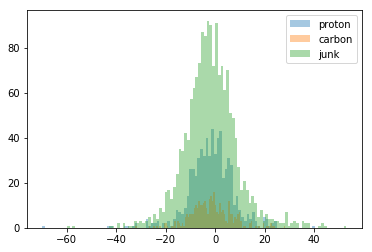

In [130]:
w = 0
e = 5
zero = original_latent[w, where_zero, :]
one = original_latent[w, where_one, :]
two = original_latent[w, where_two, : ]
n = [zero, one, two]
s = ["proton", "carbon", "junk"]

for i in range(3):
    plt.hist(n[i][:, e], bins=100, label=s[i], alpha=0.4)
    
plt.legend()

<IPython.core.display.Javascript object>


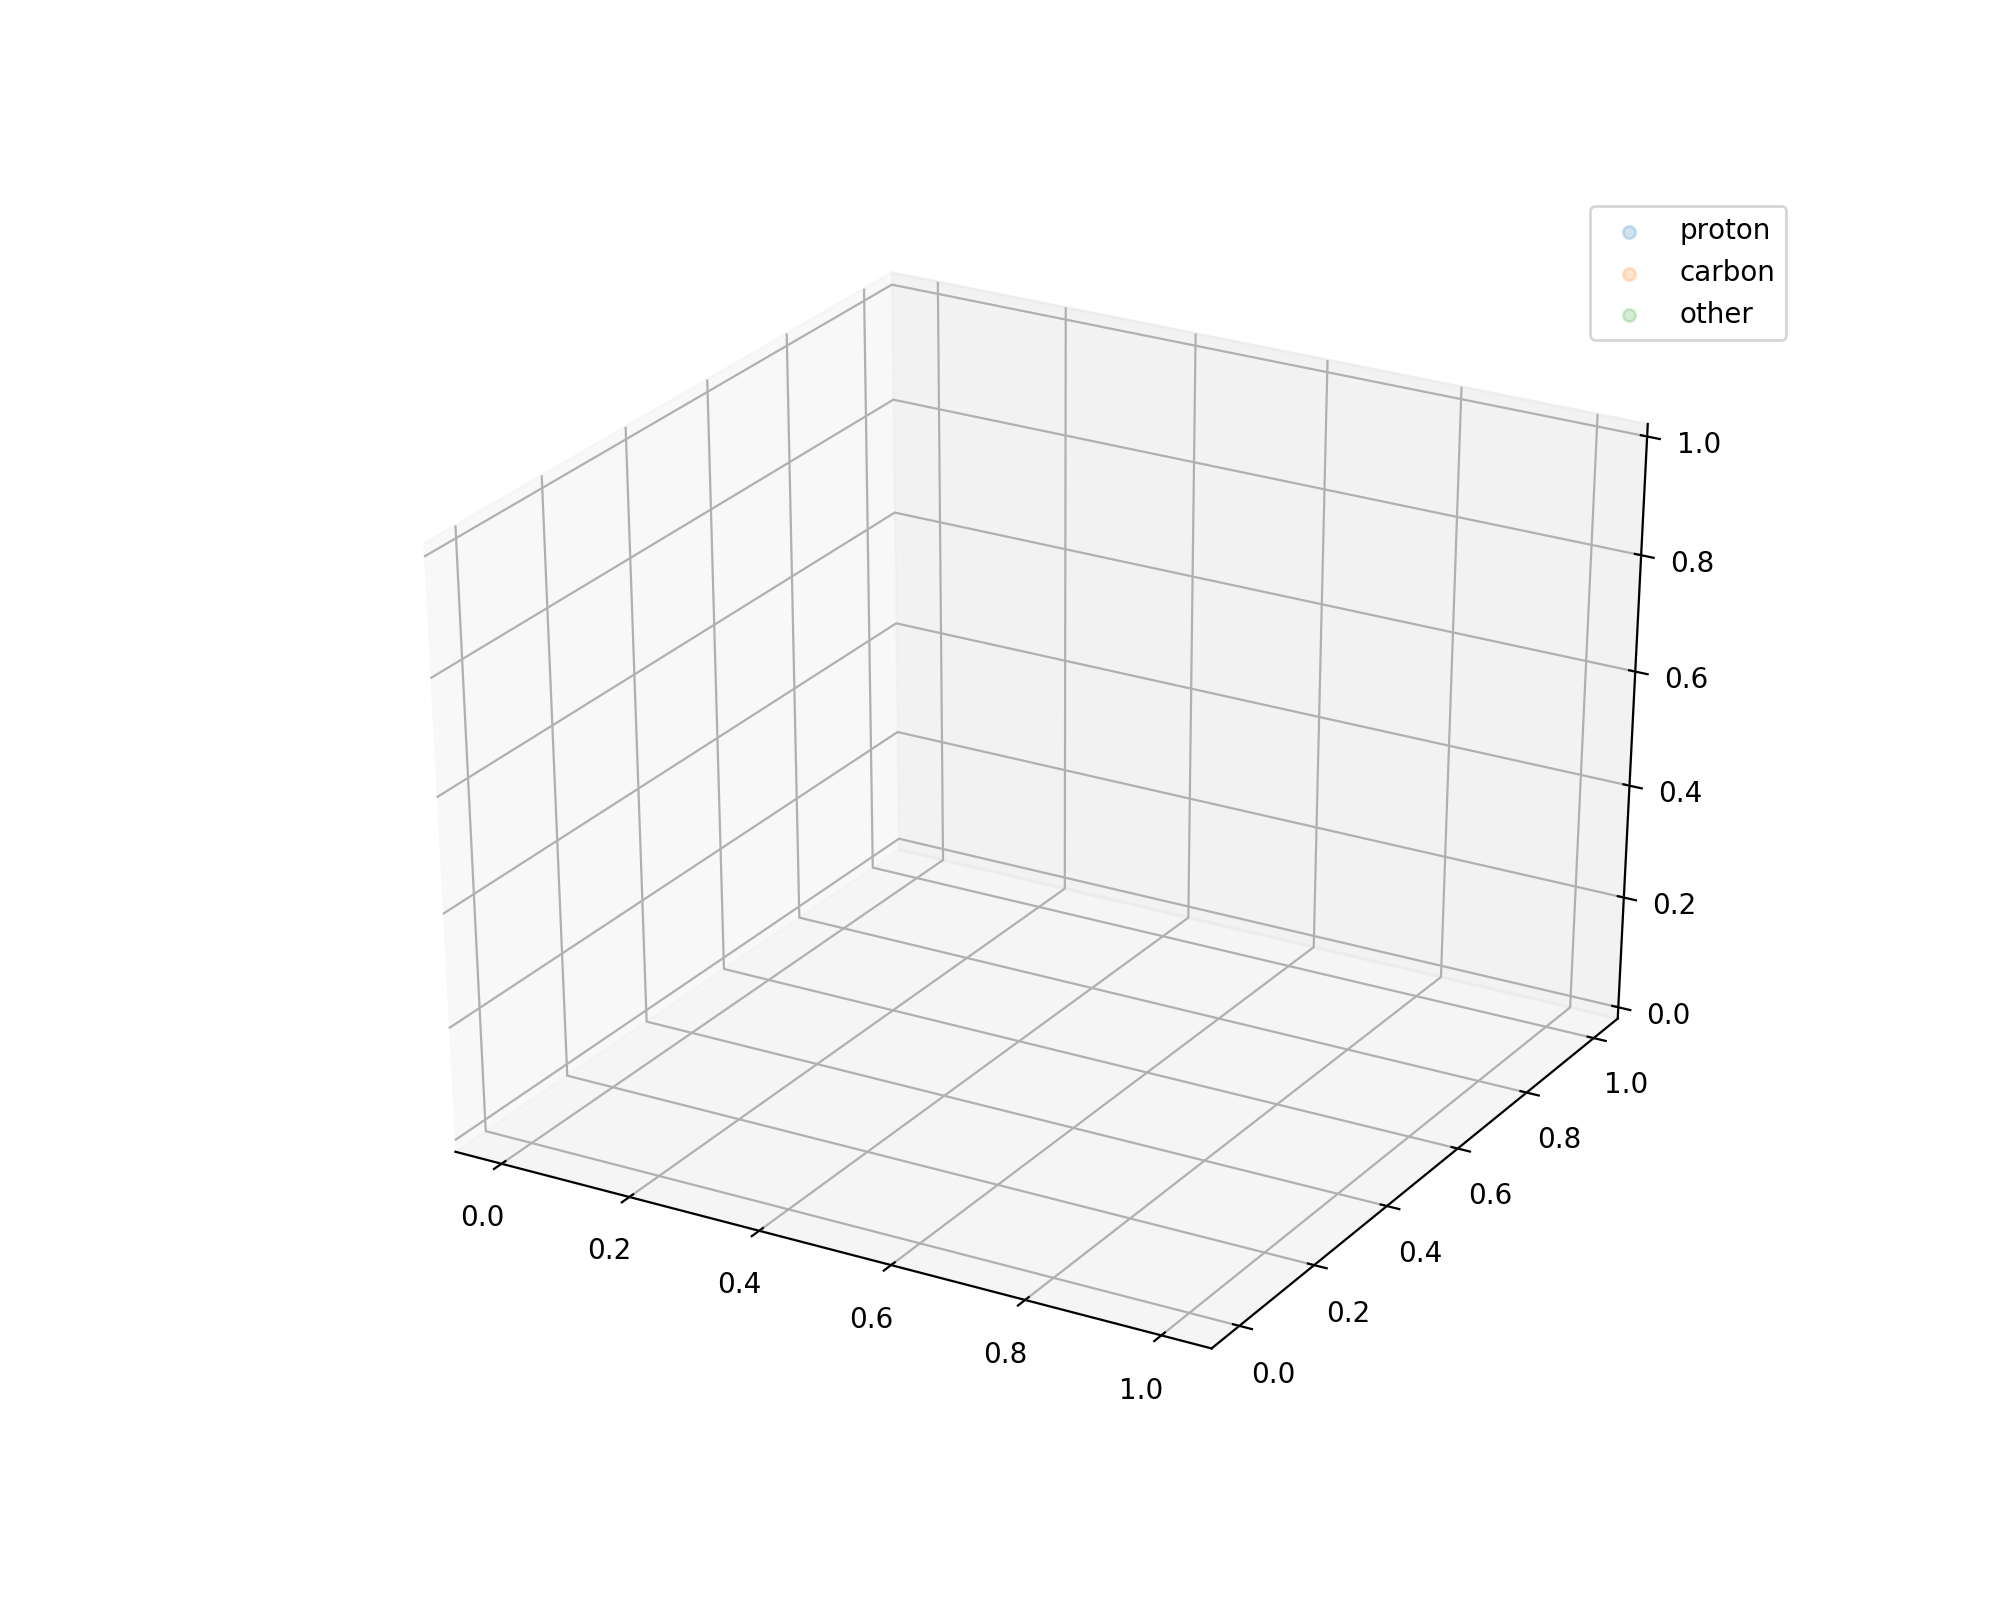

In [10]:
%matplotlib notebook

#fig, axs = plt.subplots(nrows=original_latent.shape[0], figsize=(10, 20), sharex=True, sharey=True)
fig = plt.figure(figsize=(10, 8))

all_proton = original_latent[:, where_zero[0:400], :]
all_carbon = original_latent[:, where_one[0:250], :]
all_whatever = original_latent[:, where_two[:600], :]

for i in range(1):#original_latent.shape[0]):
    ax = fig.add_subplot(
            1,#original_latent.shape[0],
            1,
            i+1,
            projection="3d"
        )
    
    i = 0

    proton = all_proton[i, :, :]
    carbon = all_carbon[i, :, :]
    noise = all_whatever[i, :, :]
    
    events = [proton, carbon, noise]
    colors = ["xb", "xr", "xg"]
    legends = ["proton", "carbon", "other"]
    
    for i in range(3):
        event = events[i]
        color = colors[i]
        legend = legends[i]
        
        x = event[:, 0]
        y = event[:, 1]
        z = event[:, 2]
        
        ax.scatter(x, y, z, color, label=legend, alpha = 0.2)
        
plt.legend()

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

In [121]:
print(original_latent.shape)

(1, 2669, 100)


In [19]:
longform_samples = np.zeros((original_latent.shape[0], 
                original_latent.shape[0]*original_latent.shape[2]))

n_latent = original_latent.shape[2]

for i, evts in enumerate(original_latent):
    longform_samples[:, i*n_latent:(i+1)*n_latent] = evts

ValueError: could not broadcast input array from shape (2135,100) into shape (1,100)

In [131]:
original_latent.shape

(1, 2669, 100)

In [146]:
oh_train_targets = OneHotEncoder(sparse=False).fit_transform(train_targets)
x_tr, x_te, y_tr, y_te = train_test_split(original_latent[0], oh_train_targets, train_size=0.8, )

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [152]:
y_tr[4]

array([0., 0., 1.])

In [153]:
pred = lr.predict(x_te)

In [159]:

pred = lr.predict(x_te)
pred.max()

1.0

In [171]:
lr = logreg((100,), n_classes=3)
earlystopping = keras.callbacks.EarlyStopping(patience=5, min_delta=0.0001,)

lr.compile(
    keras.optimizers.adam(lr=0.0001),
    "categorical_crossentropy",
    metrics=[keras.metrics.categorical_accuracy,],
)

history = lr.fit(
    x_tr,
    y_tr,
    epochs=1000,
    callbacks=[earlystopping,],
    validation_split=0.2,
)

Train on 1708 samples, validate on 427 samples
Epoch 1/1000
1708/1708 [==============================] - 2s 1ms/step - loss: 1.2253 - categorical_accuracy: 0.3302 - val_loss: 1.2002 - val_categorical_accuracy: 0.3372
Epoch 2/1000
1708/1708 [==============================] - 0s 82us/step - loss: 1.2159 - categorical_accuracy: 0.3261 - val_loss: 1.1916 - val_categorical_accuracy: 0.3419
Epoch 3/1000
1708/1708 [==============================] - 0s 88us/step - loss: 1.2094 - categorical_accuracy: 0.3437 - val_loss: 1.1836 - val_categorical_accuracy: 0.3466
Epoch 4/1000
1708/1708 [==============================] - 0s 72us/step - loss: 1.2011 - categorical_accuracy: 0.3402 - val_loss: 1.1759 - val_categorical_accuracy: 0.3583
Epoch 5/1000
1708/1708 [==============================] - 0s 66us/step - loss: 1.1961 - categorical_accuracy: 0.3501 - val_loss: 1.1676 - val_categorical_accuracy: 0.3607
Epoch 6/1000
1708/1708 [==============================] - 0s 64us/step - loss: 1.1825 - categorical

1708/1708 [==============================] - 0s 98us/step - loss: 1.0165 - categorical_accuracy: 0.5018 - val_loss: 0.9994 - val_categorical_accuracy: 0.5386
Epoch 49/1000
1708/1708 [==============================] - 0s 80us/step - loss: 1.0115 - categorical_accuracy: 0.5059 - val_loss: 0.9970 - val_categorical_accuracy: 0.5386
Epoch 50/1000
1708/1708 [==============================] - 0s 82us/step - loss: 1.0148 - categorical_accuracy: 0.5135 - val_loss: 0.9940 - val_categorical_accuracy: 0.5363
Epoch 51/1000
1708/1708 [==============================] - 0s 73us/step - loss: 1.0096 - categorical_accuracy: 0.5064 - val_loss: 0.9919 - val_categorical_accuracy: 0.5363
Epoch 52/1000
1708/1708 [==============================] - 0s 79us/step - loss: 1.0061 - categorical_accuracy: 0.5000 - val_loss: 0.9900 - val_categorical_accuracy: 0.5340
Epoch 53/1000
1708/1708 [==============================] - 0s 98us/step - loss: 1.0023 - categorical_accuracy: 0.5082 - val_loss: 0.9878 - val_categorical

1708/1708 [==============================] - 0s 92us/step - loss: 0.9213 - categorical_accuracy: 0.5761 - val_loss: 0.9161 - val_categorical_accuracy: 0.5831
Epoch 96/1000
1708/1708 [==============================] - 0s 73us/step - loss: 0.9174 - categorical_accuracy: 0.5849 - val_loss: 0.9150 - val_categorical_accuracy: 0.5878
Epoch 97/1000
1708/1708 [==============================] - 0s 81us/step - loss: 0.9184 - categorical_accuracy: 0.5796 - val_loss: 0.9143 - val_categorical_accuracy: 0.5902
Epoch 98/1000
1708/1708 [==============================] - 0s 110us/step - loss: 0.9169 - categorical_accuracy: 0.5738 - val_loss: 0.9128 - val_categorical_accuracy: 0.5925
Epoch 99/1000
1708/1708 [==============================] - 0s 75us/step - loss: 0.9149 - categorical_accuracy: 0.5749 - val_loss: 0.9114 - val_categorical_accuracy: 0.5902
Epoch 100/1000
1708/1708 [==============================] - 0s 71us/step - loss: 0.9139 - categorical_accuracy: 0.5960 - val_loss: 0.9099 - val_categoric

1708/1708 [==============================] - 0s 50us/step - loss: 0.8556 - categorical_accuracy: 0.6241 - val_loss: 0.8634 - val_categorical_accuracy: 0.6019
Epoch 143/1000
1708/1708 [==============================] - 0s 47us/step - loss: 0.8589 - categorical_accuracy: 0.6124 - val_loss: 0.8626 - val_categorical_accuracy: 0.6019
Epoch 144/1000
1708/1708 [==============================] - 0s 53us/step - loss: 0.8555 - categorical_accuracy: 0.6136 - val_loss: 0.8612 - val_categorical_accuracy: 0.6042
Epoch 145/1000
1708/1708 [==============================] - 0s 63us/step - loss: 0.8563 - categorical_accuracy: 0.6118 - val_loss: 0.8608 - val_categorical_accuracy: 0.6042
Epoch 146/1000
1708/1708 [==============================] - 0s 85us/step - loss: 0.8542 - categorical_accuracy: 0.6165 - val_loss: 0.8600 - val_categorical_accuracy: 0.6019
Epoch 147/1000
1708/1708 [==============================] - 0s 104us/step - loss: 0.8511 - categorical_accuracy: 0.6171 - val_loss: 0.8594 - val_categ

1708/1708 [==============================] - 0s 89us/step - loss: 0.8128 - categorical_accuracy: 0.6311 - val_loss: 0.8313 - val_categorical_accuracy: 0.6066
Epoch 190/1000
1708/1708 [==============================] - 0s 87us/step - loss: 0.8149 - categorical_accuracy: 0.6341 - val_loss: 0.8311 - val_categorical_accuracy: 0.6066
Epoch 191/1000
1708/1708 [==============================] - 0s 126us/step - loss: 0.8119 - categorical_accuracy: 0.6364 - val_loss: 0.8307 - val_categorical_accuracy: 0.6066
Epoch 192/1000
1708/1708 [==============================] - 0s 98us/step - loss: 0.8102 - categorical_accuracy: 0.6405 - val_loss: 0.8307 - val_categorical_accuracy: 0.6066
Epoch 193/1000
1708/1708 [==============================] - 0s 90us/step - loss: 0.8126 - categorical_accuracy: 0.6270 - val_loss: 0.8298 - val_categorical_accuracy: 0.6042
Epoch 194/1000
1708/1708 [==============================] - 0s 57us/step - loss: 0.8089 - categorical_accuracy: 0.6294 - val_loss: 0.8294 - val_categ

1708/1708 [==============================] - 0s 75us/step - loss: 0.7798 - categorical_accuracy: 0.6616 - val_loss: 0.8150 - val_categorical_accuracy: 0.6206
Epoch 237/1000
1708/1708 [==============================] - 0s 79us/step - loss: 0.7823 - categorical_accuracy: 0.6405 - val_loss: 0.8143 - val_categorical_accuracy: 0.6159


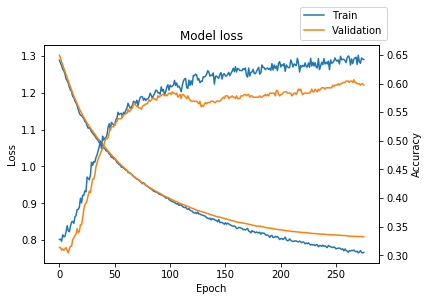

In [167]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
ax1.plot(history.history["categorical_accuracy"])
ax1.plot(history.history["val_categorical_accuracy"])
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax1.set_ylabel("Accuracy")
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=[0.75, 1.2])


In [168]:
pred = lr.predict(x_te)
confusion_matrix(y_te.argmax(-1), pred.argmax(-1))

array([[ 28,  12,  98],
       [ 12,  15,  38],
       [ 31,  24, 276]])

In [169]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight="balanced")
lr.fit(x_tr, y_tr.argmax(-1))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [170]:
from sklearn.metrics import f1_score
pred = lr.predict(x_te)
print(f1_score(y_te.argmax(-1), pred, average=None))

[0.40441176 0.26900585 0.72      ]


In [8]:
n_samples = 3
longform_n = np.zeros((
            2151,
            original_latent.shape[2]*n_samples
    ))

for i, evts in enumerate(original_latent):
    if i < n_samples:
        longform_n[:, i*n_latent:(i+1)*n_latent] = evts

In [9]:
n_samples = 1
longform_one = np.zeros((
            2151,
            original_latent.shape[2]*n_samples
    ))

for i, evts in enumerate(original_latent):
    if i < n_samples:
        longform_one[:, i*n_latent:(i+1)*n_latent] = evts

In [10]:
sample_indices = np.arange(longform_n.shape[0])

In [11]:
xtrain_ind, xtest_ind, y_train, y_test = train_test_split(sample_indices, train_targets)

X_train = longform_one[xtrain_ind]
X_test = longform_one[xtest_ind]

X_train2 = longform_samples[xtrain_ind]
X_test2 = longform_samples[xtest_ind]

X_train3 = longform_n[xtrain_ind]
X_test3 = longform_n[xtest_ind]

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

model = LogisticRegression(
            solver="lbfgs",
            multi_class="ovr",
            class_weight="balanced",
            max_iter=1000
        )

model.fit(X_train, y_train)


model2 = LogisticRegression(
            C=10,
            solver="liblinear",
            multi_class="ovr",
            class_weight="balanced",
            max_iter=1000
        )

model2.fit(X_train2, y_train)

model3 = LogisticRegression(
            solver="liblinear",
            multi_class="ovr",
            class_weight="balanced",
            max_iter=1000
        )

model3.fit(X_train3, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [13]:
print(confusion_matrix(y_test, model.predict(X_test)))
print(accuracy_score(y_test, model.predict(X_test)))

print(np.average(cross_val_score(model, X_test, y_test, cv=5)))

[[143   0   0]
 [ 60   0   0]
 [335   0   0]]
0.26579925650557623
0.2657840083073728


In [14]:
print(confusion_matrix(y_test, model2.predict(X_test2)))
print(accuracy_score(y_train, model2.predict(X_train2)))

[[ 95   8  40]
 [  4  30  26]
 [ 32  42 261]]
0.7650340979541228


In [58]:
model2.coef_.shape

(3, 200)

In [15]:
print(confusion_matrix(y_test, model3.predict(X_test3)))
print(accuracy_score(y_test, model3.predict(X_test3)))

[[ 35   8 100]
 [  6  22  32]
 [ 42  41 252]]
0.5743494423791822


In [41]:
from sklearn.neural_network import MLPClassifier

MLPClassifier(activation='relu', alpha=0.0001, batch_size=10, beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(80, 30, 10), learning_rate='constant',
       learning_rate_init=0.01, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [44]:
print(confusion_matrix(y_train3, mlp.predict(X_train3)))
print(accuracy_score(y_train3, mlp.predict(X_train3)))

[[272   5 125]
 [  7  53 147]
 [ 14  16 973]]
0.8052109181141439


In [18]:
noise_signal_targets = train_targets.copy()
noise_signal_targets[where_one] = 0
noise_signal_targets[where_two] = 1

In [19]:
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
                                        longform_samples,
                                        noise_signal_targets
                                        )

In [20]:
model_ns = LogisticRegression(
            C=1000,
            multi_class="ovr",
            class_weight="balanced"
        )

model_ns.fit(X_train_ns, y_train_ns)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [21]:
print(confusion_matrix(y_test_ns, model_ns.predict(X_test_ns)))
print(accuracy_score(y_test_ns, model_ns.predict(X_test_ns)))

[[140  79]
 [115 204]]
0.6394052044609665


In [22]:


predicted = model.predict_proba(X_test)[:,1]
class_predicted = model.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, predicted)

fig, ax = plt.subplots()

fig.suptitle("One timestep classifier of simulated events")

ax.plot(fpr, tpr, label="AUC {:.3f} | ACC {:.3f}".format(
        roc_auc_score(y_test, predicted),
        accuracy_score(y_test, class_predicted)
    ))

ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")

plt.legend()

ValueError: multiclass format is not supported

In [ ]:
predicted2 = model2.predict_proba(X_test2)[:,1]
class_predicted2 = model2.predict(X_test2)

fpr2, tpr2, thresholds2 = roc_curve(y_test2, predicted2)

fig, ax = plt.subplots()

fig.suptitle("Six timestep classifier of simulated events")

ax.plot(fpr2, tpr2, label="AUC {:.3f} | ACC {:.3f}".format(
                                        roc_auc_score(y_test2, predicted2),
                                        accuracy_score(y_test2, class_predicted2)   
                                             )
       )
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")

plt.legend()